In [1]:
import numpy as np
import cv2
from typing import Callable, Any

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [2]:
class NSTDataset(Dataset):
    def __init__(
        self,
        content_path: str,
        style_path: str,
        transforms: Callable[[Any], Any] | None = None,
    ):
        super().__init__()

        transforms = transforms or (lambda x: x)
        self.content_img = transforms(cv2.imread(content_path))
        self.style_img = transforms(cv2.imread(style_path))

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.content_img, self.style_img


class DataModule(pl.LightningDataModule):
    def __init__(self, img_sz: int, content_path, style_path):
        super().__init__()

        self.transforms = T.Compose(
            [T.ToTensor(), T.Resize(img_sz), T.Lambda(lambda t: torch.clip(t, min=0.0, max=1.0))]
        )

        self.train = NSTDataset(transforms=self.transforms, content_path=content_path, style_path=style_path)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

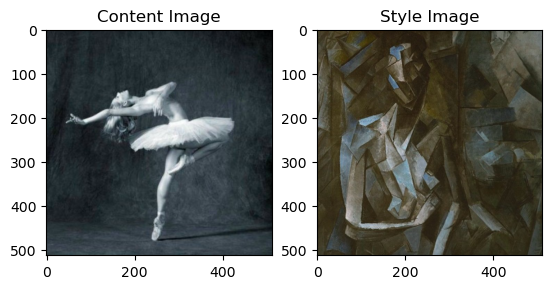

In [3]:
img_size = 512

dm = DataModule(img_sz=img_size, content_path="../data/content/dancing.jpg", style_path="../data/style/picasso.jpg")
dm.setup("fit")

con_img, sty_img = dm.train[0]
fix, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(con_img, axes=(1, 2, 0)))
axes[0].set_title("Content Image")
axes[1].imshow(np.transpose(sty_img, axes=(1, 2, 0)))
axes[1].set_title("Style Image")
plt.show()

In [4]:
from zprp.models.gatys_nst import GatysNST

######################################################################################################################################


epochs = 100
con_layers = ["conv4_2"]
sty_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
tb_logger = pl_loggers.TensorBoardLogger("logs/", name="StyleTransfer", log_graph=True)

model = GatysNST(
    content_img=con_img,
    style_img=sty_img,
    content_style_weights=(1e-5, 1e4)
)

# model = StyleTransfer(
#     con_img=con_img,
#     sty_img=sty_img,
#     con_layers=con_layers,
#     sty_layers=sty_layers,
#     lr=2e-2,
#     beta_1=0.9,
#     beta_2=0.999,
#     con_wt=1e-5,
#     sty_wt=1e4,
# )

trainer = pl.Trainer(max_epochs=epochs, logger=tb_logger, enable_progress_bar=False, enable_checkpointing=False)
# trainer = pl.Trainer(max_epochs=epochs, barebones=True)
trainer.fit(model, dm)

/home/tomek/miniconda3/envs/zprp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomek/miniconda3/envs/zprp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will 

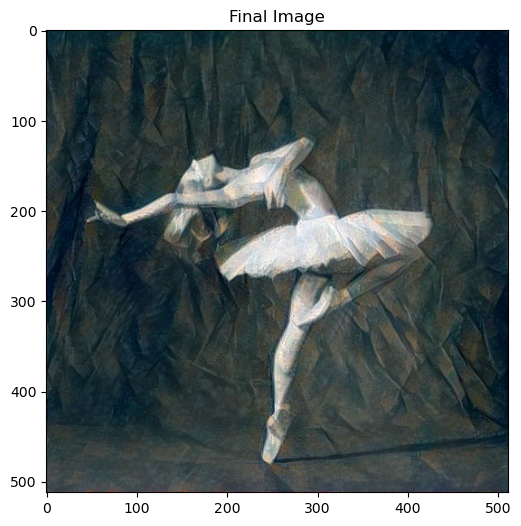

In [5]:
final_img = model.image.detach().cpu().numpy()
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(final_img, axes=(1, 2, 0))[:, :, ::-1])
plt.title("Final Image")
plt.show()